Trades: 81  |  Win-rate: 18.5%  |  Final balance: $1,360


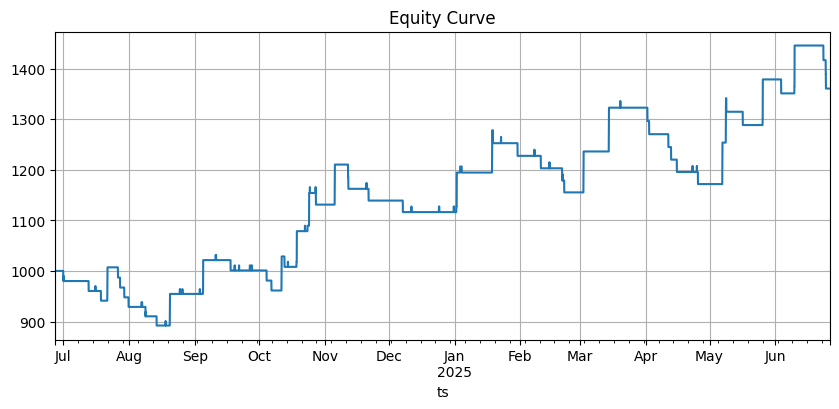

                        exit        pnl type
0  2024-06-30 20:45:00+00:00 -20.000000   SL
1  2024-07-01 02:45:00+00:00  -9.800000   SL
2  2024-07-12 19:15:00+00:00 -19.600000   SL
3  2024-07-16 01:30:00+00:00  -9.604000   SL
4  2024-07-18 14:15:00+00:00 -19.208000   SL
..                       ...        ...  ...
76 2025-06-03 16:00:00+00:00 -27.568379   SL
77 2025-06-09 23:30:00+00:00  81.051034   TP
78 2025-06-23 13:15:00+00:00 -28.908202   SL
79 2025-06-24 15:30:00+00:00 -28.330038   SL
80 2025-06-24 17:15:00+00:00 -27.763437   SL

[81 rows x 3 columns]


In [28]:
import ccxt, pandas as pd, numpy as np, matplotlib.pyplot as plt
from datetime import timezone

# ────────── CONFIG ──────────────────────────────────────────────────────
PAIR          = "SOL/USDT"
TF            = "15m"
LOOKBACK_D    = 365                 # days of history
RISK_PCT      = 0.02                # 2 % of current equity
ATR_MULT_SL   = 1.5                 # stop = 1.5 × ATR14
TP_MULT       = 3                   # hard target 3 R
PARTIAL_R1    = 1                   # scale-out half at +1 R
DAILY_DD_CAP  = 0.04                # 4 % equity
ADX_THR       = 5                 # textbook “trending” level

SESSION_H1    = 12                  # trade only 12–23 UTC
SESSION_H2    = 23
VOL_SPIKE     = 1.5                 # vol > 1.5 × 20-bar avg
EMA_FILTER    = True                # require 1-h EMA50 trend

# ────────── FETCH CANDLES ───────────────────────────────────────────────
ex      = ccxt.bybit()
since   = ex.milliseconds() - LOOKBACK_D * 86_400_000
candles = []
while since < ex.milliseconds():
    chunk = ex.fetch_ohlcv(PAIR, TF, since=since, limit=1000)
    if not chunk: break
    candles += chunk; since = chunk[-1][0] + 1

df = (pd.DataFrame(candles, columns="ts o h l c v".split())
        .assign(ts=lambda d: pd.to_datetime(d.ts, unit="ms", utc=True))
        .set_index("ts"))

# ────────── INDICATORS ─────────────────────────────────────────────────
# atr
df["atr"] = (
    pd.concat([df.h - df.l,
               (df.h - df.c.shift()).abs(),
               (df.l - df.c.shift()).abs()], axis=1)
      .max(axis=1)
      .rolling(14).mean()
)
df["ema7"]   = df.c.ewm(span=7).mean()
df["ema14"]  = df.c.ewm(span=14).mean()
df["ema28"]  = df.c.ewm(span=28).mean()

# MACD
macd_fast    = df.c.ewm(span=12).mean()
macd_slow    = df.c.ewm(span=26).mean()
df["macd"]   = macd_fast - macd_slow
df["signal"] = df.macd.ewm(span=9).mean()

# 1-hour trend filter
h1 = df.c.resample("1H").last().to_frame("close").ffill()
h1["ema50"] = h1.close.ewm(span=50).mean()

# ADX 14
tr = np.maximum.reduce([
        df.h - df.l,
        (df.h - df.c.shift()).abs(),
        (df.l - df.c.shift()).abs()
     ])
plus_dm  = np.where(df.h.diff() > df.l.diff(), df.h.diff().clip(lower=0), 0)
minus_dm = np.where(df.l.diff() > df.h.diff(), df.l.diff().abs(), 0)
tr_n     = pd.Series(tr, index=df.index).rolling(14).sum()
plus_di  = 100 * pd.Series(plus_dm, index=df.index).rolling(14).sum() / tr_n
minus_di = 100 * pd.Series(minus_dm, index=df.index).rolling(14).sum() / tr_n
dx       = 100 * (plus_di - minus_di).abs() / (plus_di + minus_di)
df["adx"] = dx.rolling(14).mean()

# Volume MA
df["vol20"] = df.v.rolling(20).mean()

# ────────── BACK-TEST LOOP ─────────────────────────────────────────────
equity        = 1_000.0
equity_curve  = []
peak          = equity
pos           = None
trades        = []

day_pnl_R     = 0     # reset each UTC day
current_day   = None

for i in range(30, len(df)):
    bar, prev = df.iloc[i], df.iloc[i-1]
    now_day   = bar.name.date()

    # ─ reset daily P&L tracker
    if current_day != now_day:
        day_pnl_R  = 0.0
        current_day = now_day

    # ─ manage open position ────────────────────────────────────────────
    if pos:
        # stop-loss
        if bar.l <= pos["sl"]:
            equity += -pos["risk"]
            day_pnl_R += -1
            trades.append({"exit": bar.name, "pnl": -pos["risk"], "type": "SL"})
            pos = None

        # first target (+1 R) for partial
        elif not pos["half"] and \
             ((bar.h - pos["entry"]) >= PARTIAL_R1 * pos["risk_per_unit"]):
            equity += 0.5 * pos["risk"]        # bank half
            pos["sl"]  = pos["entry"]          # move stop to BE
            pos["risk"]*= 0.5
            pos["half"]= True

        # take-profit full (+3 R from original entry)
        elif bar.h >= pos["tp"]:
            equity += pos["risk"] * (TP_MULT / (pos["half"] and 0.5 or 1))
            day_pnl_R += TP_MULT - (pos["half"] and 1 or 0)  # R booked today
            trades.append({"exit": bar.name,
                           "pnl":  pos["risk"] * TP_MULT/(pos['half'] and 0.5 or 1),
                           "type": "TP"})
            pos = None

    # ─ new entry allowed? ──────────────────────────────────────────────
    hour_ok   = SESSION_H1 <= bar.name.hour <= SESSION_H2
    dd_ok     = day_pnl_R > -DAILY_DD_CAP / RISK_PCT    # daily loss not blown
    atr_ok    = bar.atr > 0
    trend_ok  = True
    adx_ok    = bar.adx > ADX_THR                # NEW filter

    if EMA_FILTER:
        h1_bar = h1.index.get_loc(bar.name.floor("1H"))
        trend_ok = h1.close.iloc[h1_bar] > h1.ema50.iloc[h1_bar]

    if (hour_ok and dd_ok and atr_ok and adx_ok and  trend_ok and not pos
        and bar.c > bar.ema7 > bar.ema14 > bar.ema28
        and bar.v > VOL_SPIKE * bar.vol20
        and prev.macd < prev.signal < bar.macd):

        stop_dist = ATR_MULT_SL * bar.atr
        sl_price  = bar.c - stop_dist
        risk_usdt = equity * RISK_PCT
        qty       = risk_usdt / stop_dist

        pos = dict(entry=bar.c,
                   sl=sl_price,
                   tp=bar.c + TP_MULT * stop_dist,
                   risk=risk_usdt,
                   risk_per_unit=stop_dist,
                   half=False)

    equity_curve.append(equity)

# ────────── RESULTS ────────────────────────────────────────────────────
curve = pd.Series(equity_curve, index=df.index[-len(equity_curve):])
t_df  = pd.DataFrame(trades)
print(f"Trades: {len(t_df)}  |  Win-rate: {(t_df.type=='TP').mean():.1%}  "
      f"|  Final balance: ${equity:,.0f}")
curve.plot(title="Equity Curve", figsize=(10,4), grid=True); plt.show()
print(t_df)